- use latest version of joblib
- having a lot of null values for some reason

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import scikitplot.metrics as skplt
import joblib

In [2]:
# eng_train = pd.read_csv("lda_vecs_en.csv")
whole_data = pd.read_csv("Data/cleaned english.csv")
le = LabelEncoder()
whole_data['Y'] = le.fit_transform(whole_data["Sub-task A"])
whole_data.dropna(axis=0, subset=["monolingual"], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(whole_data['monolingual'], whole_data['Y'], random_state = 0, test_size = 0.3)

In [3]:
bow_vec = joblib.load('tfidf_en_train.pkl')

/home/rachit/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rachit/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [4]:
X_train_tweets = bow_vec.transform(X_train)
X_train_text_df = pd.DataFrame(X_train_tweets.todense(), columns=[x+'_text' for x in bow_vec.get_feature_names()])
X_train_text_df.shape

(2943, 164)

In [5]:
X_test_tweets = bow_vec.transform(X_test)
X_test_text_df = pd.DataFrame(X_test_tweets.todense(), columns=[x+'_text' for x in bow_vec.get_feature_names()])
X_test_text_df.shape

(1262, 164)

In [6]:
def run_the_mn_models(model, X_train, X_test, Y_tr, Y_te):
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    if model == 'mnb1':
        
        mn_params = {
            'fit_prior': [True],
            'alpha': [0, 0.5, 1]}
        
        M = GridSearchCV(MultinomialNB(),
                        mn_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'mnb2':
        
         mn_params = {
            'fit_prior': [False],
            'alpha': [0, 0.5, 1]}
        
         M = GridSearchCV(MultinomialNB(),
                        mn_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    else:
        print('There is an error.')
        
    M.fit(X_train_text_df.values, y_train)
     
    print(f'Train score = {M.score(X_train_text_df.values, y_train)}')
    print(f'Test score = {M.score(X_test_text_df.values, y_test)}')
    
    predictions = M.predict(X_test_text_df.values)
    predictions_train = M.predict(X_train_text_df.values)
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
    
#     #skplt.plot_roc_curve(predictions,y_test)
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    2.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.7s finished


Train score = 0.8083588175331294
Test score = 0.7908082408874801
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'alpha': 1, 'fit_prior': True}
----F1 Score, Recall, Precision----
              precision    recall  f1-score   support

           0       0.60      0.02      0.04       140
           1       0.81      0.97      0.88       989
           2       0.48      0.25      0.33       133

    accuracy                           0.79      1262
   macro avg       0.63      0.41      0.42      1262
weighted avg       0.75      0.79      0.73      1262



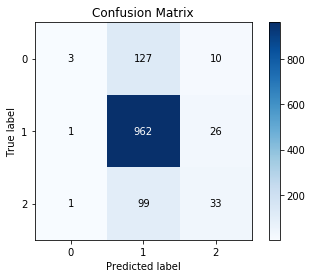

In [7]:
run_the_mn_models("mnb1", X_train_text_df, X_test_text_df, y_train, y_test)

In [8]:
def run_the_lr_models(model, X_train, X_test, Y_tr, Y_te):
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    
    if model == 'lr1':
        
        lr_1_params = {
            'penalty': ['l1'],
            'C': [1, 1.5, 2, 2.5],
            'class_weight': ['balanced'],
            'warm_start': [True, False],
            'random_state': [42],
            'solver': ['liblinear']}
        
        M = GridSearchCV(LogisticRegression(),
                        lr_1_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'lr2':
        
        lr_2_params = {
            'penalty': ['l2'],
            'C': [1, 1.5, 2, 2.5],
            'class_weight': ['balanced'],
            'warm_start': [True, False],            
            'random_state': [42],
            'solver': ['lbfgs', 'liblinear']}
        
        M = GridSearchCV(LogisticRegression(),
                        lr_2_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)

    else:
        print('There is an error.')
        
    M.fit(X_train_text_df.values, y_train)
     
    print(f'Train score = {M.score(X_train_text_df.values, y_train)}')
    print(f'Test score = {M.score(X_test_text_df.values, y_test)}')
    
    predictions = M.predict(X_test_text_df.values)
    predictions_train = M.predict(X_train_text_df.values)
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
    
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))
    
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  57 out of  80 | elapsed:    1.7s remaining:    0.7s


Train score = 0.7934080869860687
Test score = 0.7591125198098256
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'warm_start': True}
----F1 Score, Recall, Precision----
              precision    recall  f1-score   support

           0       0.32      0.24      0.28       140
           1       0.85      0.88      0.87       989
           2       0.39      0.38      0.39       133

    accuracy                           0.76      1262
   macro avg       0.52      0.50      0.51      1262
weighted avg       0.74      0.76      0.75      1262



[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.1s finished


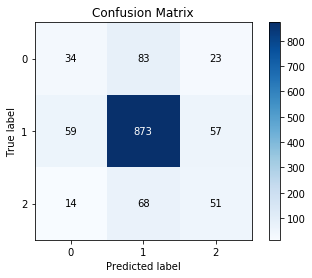

In [9]:
run_the_lr_models("lr2", X_train_text_df, X_test_text_df, y_train, y_test)

In [10]:
def run_the_sv_models(model, X_train, X_test, Y_tr, Y_te):   
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    if model == 'sv1':
        
        sv_params = {
            'kernel': ['rbf'], 
            'gamma': [1e-3, 1e-4],
            'C': [1, 10, 100, 1000] }
        
        M = GridSearchCV(SVC(probability=True),
                        sv_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'sv2':
        
        
        sv_params = {
            'kernel': ['rbf'], 
            'gamma': [0.01, 1, 10, 100],
            'C': [1, 10, 100, 1000] }

        M = GridSearchCV(SVC(probability=True),
                        sv_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    else:
        print("Invalid Model!")
        
    M.fit(X_train_text_df.values, y_train)
      
    #save in picle file
    joblib.dump(M, "SVM_TFIDF.pkl")
     
    print(f'Train score = {M.score(X_train_text_df.values, y_train)}')
    print(f'Test score = {M.score(X_test_text_df.values, y_test)}')
    
    predictions = M.predict(X_test_text_df.values)
    predictions_train = M.predict(X_train_text_df.values)
    
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.3min finished


Train score = 0.8114169215086646
Test score = 0.7908082408874801
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
----F1 Score, Recall, Precision----
              precision    recall  f1-score   support

           0       0.50      0.03      0.05       140
           1       0.81      0.97      0.89       989
           2       0.46      0.25      0.32       133

    accuracy                           0.79      1262
   macro avg       0.59      0.42      0.42      1262
weighted avg       0.74      0.79      0.73      1262



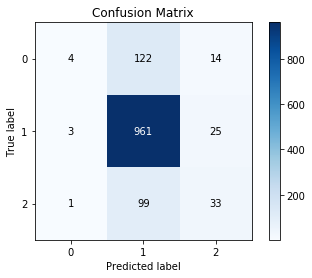

In [11]:
run_the_sv_models("sv2", X_train_text_df, X_test_text_df, y_train, y_test)